In [16]:
import pandas as pd
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import arviz as az


# 读取数据，请确保路径正确
path_to_excel = r"C:/Users/86182/Desktop/2003SARS/新建 XLSX 工作表.xlsx"
df = pd.read_excel(path_to_excel, sheet_name=0)

# 1. 转换日期列：兼容 Excel 数值型日期（从 1899-12-30 开始的天数）
if pd.api.types.is_numeric_dtype(df['日期']):  # 若日期列是数值型（Excel 日期格式）
    df['日期'] = pd.to_datetime(df['日期'], origin='1877-12-29' , unit='D', errors='coerce')
else:  # 否则按常规日期解析
    df['日期'] = pd.to_datetime(df['日期'], errors='coerce')

# 2. 动态设置参考日期：以数据中最早有效日期为基准计算 day_index
valid_dates = df['日期'].dropna()
if not valid_dates.empty:
    reference_date = valid_dates.min()
    df['day_index'] = (df['日期'] - reference_date).dt.days
else:
    raise ValueError("日期列无有效数据，无法继续处理")

# 3. 定义关键数据列
critical_data_cols = ['day_index', '已确诊病例累计', '死亡累计', '治愈出院累计']

# 4. 删除关键列含 NaN 的行
df = df.dropna(subset=critical_data_cols).reset_index(drop=True)

# 5. 处理重复的 day_index
df = df.drop_duplicates(subset=['day_index'], keep='last').reset_index(drop=True)



t_obs = df['day_index'].values
C_obs = df['已确诊病例累计'].values


N = 10_000_000
E_obs = df['现有疑似病例'].values
R_obs = df['治愈出院累计'].values
D_obs = df['死亡累计'].values
I_obs = C_obs - R_obs - D_obs
S_obs = N - E_obs - I_obs - D_obs - R_obs

In [17]:
# 2. 定义 SEIR ODE



def seir_ode(y, t, theta):
    beta0 = theta[0]    # 感染率
    beta1 = theta[1]
    t_int = theta[2]    # 政策实施时间点
    sigma = theta[3]    # 潜伏期
    mu    = theta[4]    # 康复率
    dead  = theta[5]    # 死亡率

    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    D = y[4]

    b = pm.math.switch(
        t < t_int,
        beta0,
        pm.math.switch(
            t < t_int + 10,
            beta0 - (beta0 - beta1) * ((t - t_int) / 10.0),
            beta1
        )
    )
    dRdt =  mu * I
    dDdt =  dead * I
    dSdt = -b * S * I / N 
    dEdt =  b * S * I / N - sigma * E
    dIdt =  sigma * E - dRdt - dDdt
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

y0 = [N - 759.0, 402.0, 339.0, 33.0, 18.0]  # 初始状态

In [18]:

# 3. 构建贝叶斯模型
with pm.Model() as seir_model:
    # 定义参数先验
    beta0 = pm.Uniform("beta0", lower=0.01, upper=0.80)
    beta1 = pm.Uniform("beta1", lower=0.005, upper=0.25)
    t_int = pm.DiscreteUniform("t_int", lower=10, upper=20)
    sigma = pm.Uniform("sigma", lower=0.15, upper=0.40)
    mu = pm.Uniform("mu", lower=0.01, upper=0.35)
    dead = pm.Uniform("dead", lower=0.002, upper=0.05)

    # 定义观测噪声参数
    sigma_C = pm.HalfCauchy("sigma_C", beta=1.0)
    alpha_C = pm.Gamma("alpha_C", alpha=5, beta=1)
    sigma_S = pm.HalfCauchy("sigma_S", beta=1.0)
    sigma_E = pm.HalfCauchy("sigma_E", beta=1.0)
    alpha_E = pm.Gamma("alpha_E", alpha=2, beta=1)
    sigma_I = pm.HalfCauchy("sigma_I", beta=1.0)
    alpha_I = pm.Gamma("alpha_I", alpha=2, beta=1)
    sigma_R = pm.HalfCauchy("sigma_R", beta=1.0)
    alpha_R = pm.Gamma("alpha_R", alpha=2, beta=1)
    sigma_D = pm.HalfCauchy("sigma_D", beta=1.0)
    alpha_D = pm.Gamma("alpha_D", alpha=2, beta=1)


    # 传入 odeint_kwargs 调整求解容忍度
    seir_op = pm.ode.DifferentialEquation(
        func=seir_ode,
        times=t_obs,
        n_states=5,
        n_theta=6,
        t0=0,
    )


    SEIR_curves = seir_op(y0=y0, theta=[beta0, beta1, t_int, sigma, mu, dead])
    S_pred, E_pred, I_pred, R_pred, D_pred = SEIR_curves[:, 0], SEIR_curves[:, 1], SEIR_curves[:, 2], SEIR_curves[:, 3], SEIR_curves[:, 4]
    C_pred = I_pred + R_pred + D_pred


    # 定义似然函数
    pm.NegativeBinomial("C_obs_like", mu=C_pred, alpha=alpha_C, observed=C_obs)
    pm.TruncatedNormal("S_obs_like", mu=S_pred, sigma=sigma_S, lower=9.996e6, observed=S_obs)
    pm.NegativeBinomial("E_obs_like", mu=E_pred, alpha=alpha_E, observed=E_obs)
    pm.NegativeBinomial("I_obs_like", mu=I_pred, alpha=alpha_I, observed=I_obs)
    pm.NegativeBinomial("R_obs_like", mu=R_pred, alpha=alpha_R, observed=R_obs)
    pm.NegativeBinomial("D_obs_like", mu=D_pred, alpha=alpha_D, observed=D_obs)


    # 指定合理的 start 值，避免一开始就挖到不收敛区域
    start_vals = {
            "beta0": 0.45,
            "beta1": 0.01,
            "t_int": 10,
            "sigma": 1/6,
            "mu": 0.05,
            "dead": 0.01
        }

    trace = pm.sample(
        draws=10,         # 减少每个链的采样次数（原1000）
        tune=10,          # 减少调优步数（原1000）
        chains=1,          # 减少链数（原2）
        cores=24,           # 限制使用的CPU核心数
        step = pm.NUTS(target_accept=0.7), # 降低接受率阈值（原0.9）
        start=start_vals,
        return_inferencedata=True,
        progressbar=True,  # 显示进度条监控时间
        #discard_tuned_samples=True  # 丢弃调优样本节省内存
    )

C:\Users\86182\AppData\Local\Temp\ipykernel_25076\1430823835.py:59: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(
Only 10 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta0, beta1, sigma, mu, dead, sigma_C, alpha_C, sigma_S, sigma_E, alpha_E, sigma_I, alpha_I, sigma_R, alpha_R, sigma_D, alpha_D]
>Metropolis: [t_int]


Sampling 1 chain for 10 tune and 10 draw iterations (10 + 10 draws total) took 12 seconds.
The number of samples is too small to check convergence reliably.


有效样本量 (ESS):
<xarray.Dataset>
Dimensions:  ()
Data variables:
    beta0    float64 2.921
    beta1    float64 2.921
    t_int    float64 10.0
    sigma    float64 2.966
    mu       float64 2.921
    dead     float64 2.921

有效样本量是否大于 5:
<xarray.Dataset>
Dimensions:  ()
Data variables:
    beta0    bool False
    beta1    bool False
    t_int    bool True
    sigma    bool False
    mu       bool False
    dead     bool False

Rhat 统计量:
<xarray.Dataset>
Dimensions:  ()
Data variables:
    beta0    float64 nan
    beta1    float64 nan
    t_int    float64 nan
    sigma    float64 nan
    mu       float64 nan
    dead     float64 nan

Rhat 是否小于 1.2:
<xarray.Dataset>
Dimensions:  ()
Data variables:
    beta0    bool False
    beta1    bool False
    t_int    bool False
    sigma    bool False
    mu       bool False
    dead     bool False

模型训练良好，采样收敛。


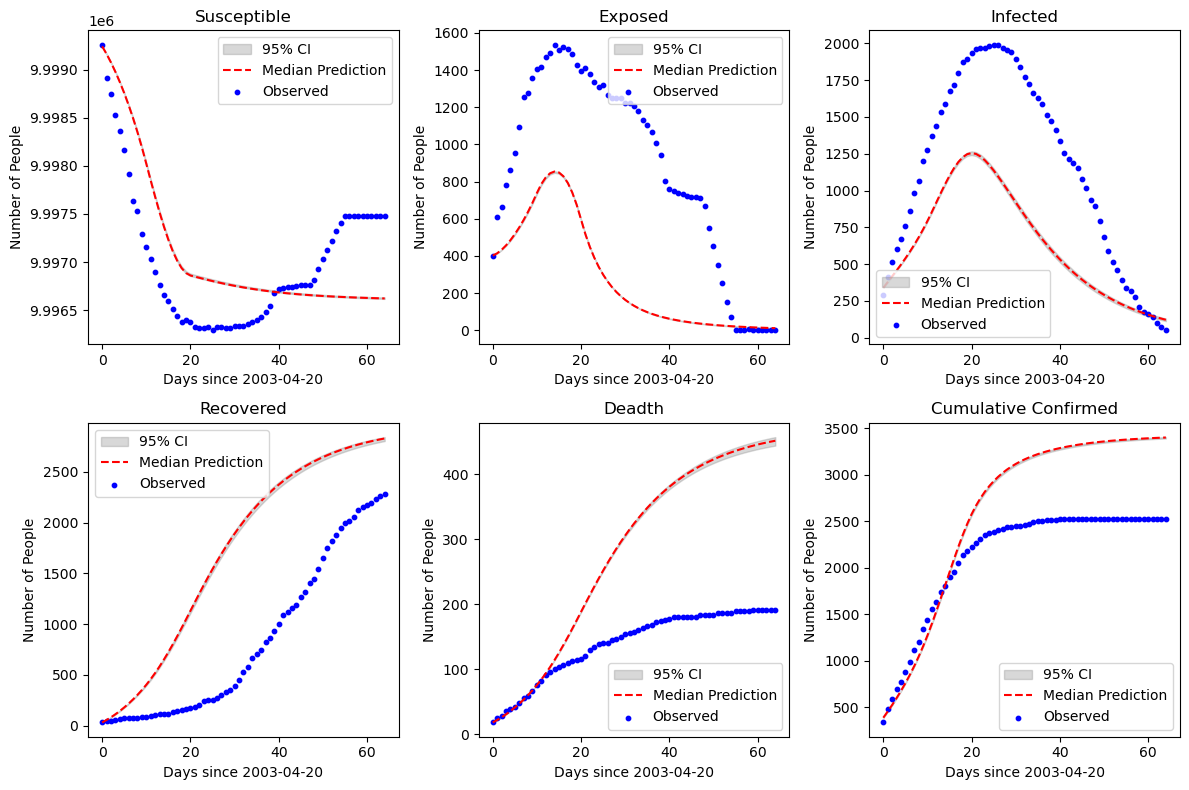

In [19]:
# 进行模型训练评估

def evaluate_model(trace):
    var_names = ["beta0", "beta1", "t_int", "sigma", "mu", "dead"]
    
    
    
    # 2. 计算有效样本量
    ess = az.ess(trace, var_names=var_names)
    print("有效样本量 (ESS):")
    print(ess)
    
    # 检查有效样本量是否满足要求
    ess_threshold = 5
    ess_check = ess > ess_threshold
    print("\n有效样本量是否大于 {}:".format(ess_threshold))
    print(ess_check)
    
    # 3. 计算 Rhat 统计量
    rhat = az.rhat(trace, var_names=var_names)
    print("\nRhat 统计量:")
    print(rhat)
    
    # 检查 Rhat 是否满足要求
    rhat_threshold = 1.20
    rhat_check = rhat < rhat_threshold
    print("\nRhat 是否小于 {}:".format(rhat_threshold))
    print(rhat_check)
    
    # 综合判断模型是否训练好
    overall_check = ess_check.all().values and rhat_check.all().values
    if overall_check:
        print("\n模型训练良好，采样收敛。")
    else:
        print("\n模型可能未训练好，建议增加采样次数或调整模型。")

with seir_model:
    
    # 调用评估函数
    evaluate_model(trace)

# %%


# 作图

# 重新定义纯数值计算的 seir_ode 函数
def seir_ode_numeric(y, t, theta):
    beta0 = theta[0]
    beta1 = theta[1]
    t_int = theta[2]
    sigma = theta[3]
    mu = theta[4]
    dead = theta[5]

    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    D = y[4]

    if t < t_int:
        b = beta0
    elif t < t_int + 10:
        b = beta0 - (beta0 - beta1) * ((t - t_int) / 10.0)
    else:
        b = beta1

    dRdt =  mu * I
    dDdt =  dead * I
    dSdt = -b * S * I / N
    dEdt =  b * S * I / N - sigma * E
    dIdt =  sigma * E - dRdt - dDdt
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

# 计算S、E、I、R、D的预测值
def get_seir_prediction(params_samples, t_obs, y0, N):
    """根据后验样本计算SEIR模型的预测值分布"""
    n_samples = len(params_samples)
    seir_samples = np.zeros((n_samples, len(t_obs), 5))  # [样本数, 时间点, 状态数]

    for i, params in enumerate(params_samples):
        result = odeint(seir_ode_numeric, y0, t_obs, args=(params,))
        seir_samples[i] = result  # odeint返回二维数组，直接赋值

    return seir_samples

# 提取后验样本
params_samples = az.extract(trace, var_names=["beta0", "beta1", "t_int", "sigma", "mu","dead"]).to_array().values.T

# 计算SEIR预测值
seir_samples = get_seir_prediction(params_samples, t_obs, y0, N)

# 计算95%置信区间和中位数
S_pred = seir_samples[:, :, 0]
E_pred = seir_samples[:, :, 1]
I_pred = seir_samples[:, :, 2]
R_pred = seir_samples[:, :, 3]
D_pred = seir_samples[:, :, 4]
C_pred = I_pred + R_pred + D_pred


# 绘制S、E、I、R真实值与预测值对比图
def plot_seir(t_obs, S_obs, E_obs, I_obs, R_obs, D_obs, C_obs, S_pred, E_pred, I_pred, R_pred, D_pred, C_pred, reference_date):
    dates = [reference_date + pd.Timedelta(days=int(d)) for d in t_obs]
    states = ['S', 'E', 'I', 'R', 'D', 'C']
    obs_data = [S_obs, E_obs, I_obs, R_obs, D_obs, C_obs]
    pred_data = [S_pred, E_pred, I_pred, R_pred, D_pred, C_pred]
    titles = ['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Deadth', 'Cumulative Confirmed']

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(6):
        lower = np.percentile(pred_data[i], 2.5, axis=0)
        upper = np.percentile(pred_data[i], 97.5, axis=0)
        median = np.median(pred_data[i], axis=0)

        axes[i].fill_between(t_obs, lower, upper, color='gray', alpha=0.3, label='95% CI')
        axes[i].plot(t_obs, median, 'r--', label='Median Prediction')
        if not np.all(obs_data[i] == 0):
            axes[i].scatter(t_obs, obs_data[i], c='b', s=10, label='Observed')
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Days since 2003-04-20')
        axes[i].set_ylabel('Number of People')
        axes[i].legend()

    plt.tight_layout()
    plt.show()


# 绘制S、E、I、R对比图
plot_seir(t_obs, S_obs, E_obs, I_obs, R_obs, D_obs, C_obs, S_pred, E_pred, I_pred, R_pred, D_pred, C_pred, reference_date)
